# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

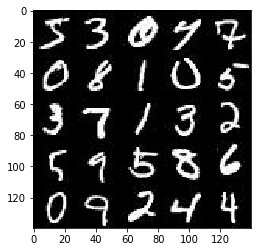

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

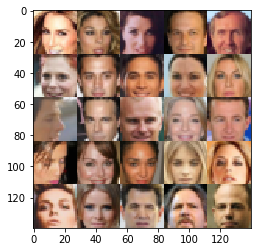

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    #real input
    print("Input Stage")
    real_in = tf.placeholder(tf.float32, (None,image_width, image_height, image_channels))
    #z-data
    z_in = tf.placeholder(tf.float32, (None, z_dim))
    # learning rate
    lr = tf.placeholder(tf.float32)

    return real_in, z_in, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Input Stage
Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        print("disciminator stage")
        #Input image:28*28*3
        in1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(in1*alpha, in1)
        #input image:14*14*64
        print(in1.shape)
        
        in2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(in2, training=True)
        relu2 = tf.maximum(bn2*alpha, bn2)
        #input image:7*7*256
        print(in2.shape)
        
        """       
        in3 = tf.layers.conv2d(relu2, 256, 5, strides=1, padding='same')
        bn3 = tf.layers.batch_normalization(in2, training=True)
        relu3 = tf.maximum(bn3*alpha, bn3)
        print(in3.shape)
        """
        
        #Flatten 
        flat = tf.reshape(relu2, (-1, 7*7*128))
        logits_dis = tf.layers.dense(flat,1)
        out_dis = tf.sigmoid(logits_dis)
        #print(out_dis.shape,out_dis, logits_dis.shape, logits_dis)
        return out_dis, logits_dis


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

disciminator stage
(?, 14, 14, 64)
(?, 7, 7, 128)
disciminator stage
(?, 14, 14, 64)
(?, 7, 7, 128)
Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.08
    with tf.variable_scope('generator', reuse= not is_train):
        print("Generator Stage")
        # fully connected layer
        in0 = tf.layers.dense(z, 7*7*128)
        #print(in0.shape)
        
        # start tof convolution track.
        in1 = tf.reshape(in0, (-1, 7,7,128))
        bn1 = tf.layers.batch_normalization(in1, training=True)
        relu1 = tf.maximum(bn1*alpha, bn1)
        #print(in1.shape)
        # image shape: 7*7*128
        
        in2 = tf.layers.conv2d_transpose(relu1, 64, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(in2, training=True)
        relu2 = tf.maximum(bn2*alpha, bn2)
        #print(in2.shape)
        # image shape: 14*14*64
        
        in3 = tf.layers.conv2d_transpose(relu2, 32, 5, strides=1, padding='same')
        bn3 = tf.layers.batch_normalization(in3, training=True)
        relu3 = tf.maximum(bn3*alpha, bn3)
        # image shape: 14*14*32
        
        logits_gen = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=2, padding='same')
        # image shape: 28*28*out_channel_dim  
        out_gen = tf.tanh(logits_gen)
        print(out_gen.shape)
        
    return out_gen


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Generator Stage
(?, 28, 28, 5)
Generator Stage
(?, 28, 28, 5)
Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    #model outputs
    smooth = 0.1
    g_logits = generator(input_z, out_channel_dim)
    d_out_real, d_logits_real = discriminator(input_real)
    d_out_fake, d_logits_fake = discriminator(g_logits, reuse=True)
    
    # Generator loss
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_out_fake)))
    
    # Discriminator Loss
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_out_real)*(1-smooth)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_out_fake)))
    
    #total loss
    d_loss_total = d_loss_real+d_loss_fake
    g_loss_total = g_loss
    
    return d_loss_total, g_loss_total


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Generator Stage
(?, 28, 28, 4)
disciminator stage
(?, 14, 14, 64)
(?, 7, 7, 128)
disciminator stage
(?, 14, 14, 64)
(?, 7, 7, 128)
Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:

def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    d_train_opt = tf.train.AdamOptimizer(
        learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(
            learning_rate, beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, img_width, img_height, img_channels = data_shape
    
    real_input, z_input, lr = model_inputs(
        img_width, img_height, img_channels, z_dim)
    
    d_loss, g_loss = model_loss(real_input, z_input, img_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    print_every = 10
    show_every = 100
    losses = []
    n_images = 25
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0
                z_sample = np.random.uniform(-1, 1, (batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={
                        real_input: batch_images, z_input: z_sample, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={
                        z_input: z_sample, lr: learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({z_input: z_sample, real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: z_sample})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, z_input, img_channels, data_image_mode)
    fig, ax = plt.subplots()
    losses=np.array(losses)
    plt.plot(losses.T[0], label='discriminator',alpha=0.5 )
    plt.plot(losses.T[1], label='generator',alpha=0.5)
    plt.title("discriminator-generator Losses")
    plt.legend()
    

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Input Stage
Generator Stage
(?, 28, 28, 1)
disciminator stage
(?, 14, 14, 64)
(?, 7, 7, 128)
disciminator stage
(?, 14, 14, 64)
(?, 7, 7, 128)
Epoch 1/2... Discriminator Loss: 1.2393... Generator Loss: 0.6530
Epoch 1/2... Discriminator Loss: 1.6863... Generator Loss: 1.6369
Epoch 1/2... Discriminator Loss: 2.1765... Generator Loss: 0.2749
Epoch 1/2... Discriminator Loss: 1.1731... Generator Loss: 2.4105
Epoch 1/2... Discriminator Loss: 1.6654... Generator Loss: 0.4775
Epoch 1/2... Discriminator Loss: 1.5407... Generator Loss: 0.4952
Epoch 1/2... Discriminator Loss: 1.4889... Generator Loss: 0.5730
Epoch 1/2... Discriminator Loss: 1.0303... Generator Loss: 1.1389
Epoch 1/2... Discriminator Loss: 1.1880... Generator Loss: 1.0200
Epoch 1/2... Discriminator Loss: 1.0978... Generator Loss: 0.9370
Generator Stage
(?, 28, 28, 1)


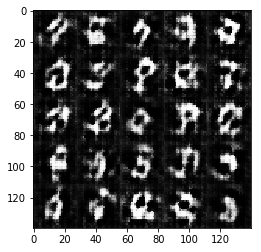

Epoch 1/2... Discriminator Loss: 1.1692... Generator Loss: 1.1537
Epoch 1/2... Discriminator Loss: 1.3616... Generator Loss: 1.1872
Epoch 1/2... Discriminator Loss: 1.0735... Generator Loss: 1.6434
Epoch 1/2... Discriminator Loss: 1.4875... Generator Loss: 1.8067
Epoch 1/2... Discriminator Loss: 1.3868... Generator Loss: 1.8442
Epoch 1/2... Discriminator Loss: 2.0194... Generator Loss: 0.3079
Epoch 1/2... Discriminator Loss: 1.4477... Generator Loss: 0.5354
Epoch 1/2... Discriminator Loss: 1.2706... Generator Loss: 0.9738
Epoch 1/2... Discriminator Loss: 1.0960... Generator Loss: 1.3170
Epoch 1/2... Discriminator Loss: 1.4792... Generator Loss: 0.5512
Generator Stage
(?, 28, 28, 1)


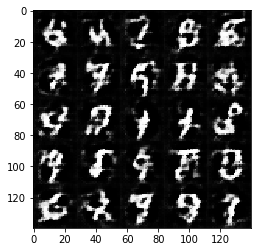

Epoch 1/2... Discriminator Loss: 1.4979... Generator Loss: 1.7922
Epoch 1/2... Discriminator Loss: 1.1860... Generator Loss: 0.8758
Epoch 1/2... Discriminator Loss: 1.7121... Generator Loss: 0.3802
Epoch 1/2... Discriminator Loss: 1.2001... Generator Loss: 0.9620
Epoch 1/2... Discriminator Loss: 1.4398... Generator Loss: 1.4331
Epoch 1/2... Discriminator Loss: 1.2007... Generator Loss: 1.6468
Epoch 1/2... Discriminator Loss: 1.2870... Generator Loss: 1.6647
Epoch 1/2... Discriminator Loss: 1.5361... Generator Loss: 0.5090
Epoch 1/2... Discriminator Loss: 1.3275... Generator Loss: 1.6249
Epoch 1/2... Discriminator Loss: 1.2422... Generator Loss: 0.8809
Generator Stage
(?, 28, 28, 1)


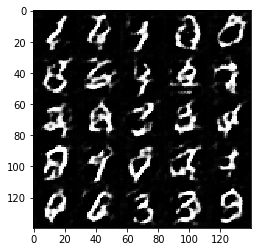

Epoch 1/2... Discriminator Loss: 1.0847... Generator Loss: 1.1490
Epoch 1/2... Discriminator Loss: 1.2224... Generator Loss: 0.7882
Epoch 1/2... Discriminator Loss: 1.2416... Generator Loss: 1.6715
Epoch 1/2... Discriminator Loss: 1.1864... Generator Loss: 1.4013
Epoch 1/2... Discriminator Loss: 1.5959... Generator Loss: 0.4420
Epoch 1/2... Discriminator Loss: 1.4956... Generator Loss: 0.4834
Epoch 1/2... Discriminator Loss: 1.3995... Generator Loss: 1.6332
Epoch 1/2... Discriminator Loss: 1.0792... Generator Loss: 1.4445
Epoch 1/2... Discriminator Loss: 1.8327... Generator Loss: 0.3437
Epoch 1/2... Discriminator Loss: 1.2420... Generator Loss: 1.3413
Generator Stage
(?, 28, 28, 1)


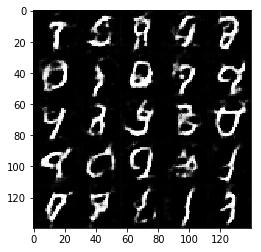

Epoch 1/2... Discriminator Loss: 1.4088... Generator Loss: 1.5900
Epoch 1/2... Discriminator Loss: 1.1915... Generator Loss: 0.7164
Epoch 1/2... Discriminator Loss: 1.2728... Generator Loss: 1.5266
Epoch 1/2... Discriminator Loss: 1.1259... Generator Loss: 0.8664
Epoch 1/2... Discriminator Loss: 1.1903... Generator Loss: 0.8776
Epoch 1/2... Discriminator Loss: 1.1505... Generator Loss: 0.9085
Epoch 2/2... Discriminator Loss: 1.2672... Generator Loss: 1.2683
Epoch 2/2... Discriminator Loss: 1.1253... Generator Loss: 1.1844
Epoch 2/2... Discriminator Loss: 1.4177... Generator Loss: 0.5620
Epoch 2/2... Discriminator Loss: 1.2131... Generator Loss: 0.9354
Generator Stage
(?, 28, 28, 1)


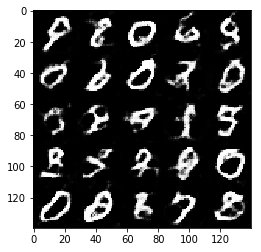

Epoch 2/2... Discriminator Loss: 1.2302... Generator Loss: 0.8115
Epoch 2/2... Discriminator Loss: 1.2177... Generator Loss: 0.9623
Epoch 2/2... Discriminator Loss: 1.2688... Generator Loss: 0.8203
Epoch 2/2... Discriminator Loss: 1.2815... Generator Loss: 0.7914
Epoch 2/2... Discriminator Loss: 1.3519... Generator Loss: 1.3748
Epoch 2/2... Discriminator Loss: 1.1527... Generator Loss: 1.3641
Epoch 2/2... Discriminator Loss: 1.3245... Generator Loss: 0.6490
Epoch 2/2... Discriminator Loss: 1.3736... Generator Loss: 1.3126
Epoch 2/2... Discriminator Loss: 1.1864... Generator Loss: 1.0570
Epoch 2/2... Discriminator Loss: 1.4390... Generator Loss: 0.5129
Generator Stage
(?, 28, 28, 1)


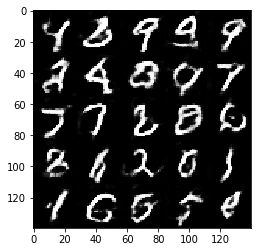

Epoch 2/2... Discriminator Loss: 1.4044... Generator Loss: 0.7515
Epoch 2/2... Discriminator Loss: 1.2368... Generator Loss: 0.8829
Epoch 2/2... Discriminator Loss: 1.5207... Generator Loss: 1.8476
Epoch 2/2... Discriminator Loss: 1.3799... Generator Loss: 0.6177
Epoch 2/2... Discriminator Loss: 1.2001... Generator Loss: 1.0954
Epoch 2/2... Discriminator Loss: 1.4167... Generator Loss: 0.5977
Epoch 2/2... Discriminator Loss: 1.3920... Generator Loss: 0.8483
Epoch 2/2... Discriminator Loss: 1.2826... Generator Loss: 0.9254
Epoch 2/2... Discriminator Loss: 1.2252... Generator Loss: 1.3208
Epoch 2/2... Discriminator Loss: 1.2837... Generator Loss: 0.6918
Generator Stage
(?, 28, 28, 1)


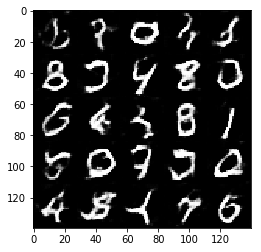

Epoch 2/2... Discriminator Loss: 1.3411... Generator Loss: 0.8275
Epoch 2/2... Discriminator Loss: 1.3540... Generator Loss: 0.6169
Epoch 2/2... Discriminator Loss: 1.5525... Generator Loss: 1.2182
Epoch 2/2... Discriminator Loss: 1.3941... Generator Loss: 0.9316
Epoch 2/2... Discriminator Loss: 1.2177... Generator Loss: 0.9433
Epoch 2/2... Discriminator Loss: 1.2736... Generator Loss: 1.0168
Epoch 2/2... Discriminator Loss: 1.3089... Generator Loss: 0.7282
Epoch 2/2... Discriminator Loss: 1.3657... Generator Loss: 1.1571
Epoch 2/2... Discriminator Loss: 1.4950... Generator Loss: 0.5407
Epoch 2/2... Discriminator Loss: 1.2231... Generator Loss: 0.8972
Generator Stage
(?, 28, 28, 1)


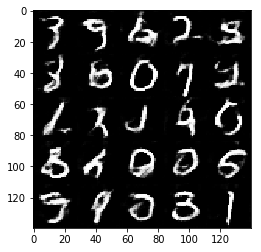

Epoch 2/2... Discriminator Loss: 1.2902... Generator Loss: 1.0285
Epoch 2/2... Discriminator Loss: 1.6857... Generator Loss: 1.9648
Epoch 2/2... Discriminator Loss: 1.3018... Generator Loss: 0.9566
Epoch 2/2... Discriminator Loss: 1.4896... Generator Loss: 1.8275
Epoch 2/2... Discriminator Loss: 1.2721... Generator Loss: 0.6306
Epoch 2/2... Discriminator Loss: 1.3012... Generator Loss: 0.7325
Epoch 2/2... Discriminator Loss: 1.1921... Generator Loss: 0.9360
Epoch 2/2... Discriminator Loss: 1.2270... Generator Loss: 1.1771
Epoch 2/2... Discriminator Loss: 1.2670... Generator Loss: 0.7039
Epoch 2/2... Discriminator Loss: 1.3684... Generator Loss: 0.9050
Generator Stage
(?, 28, 28, 1)


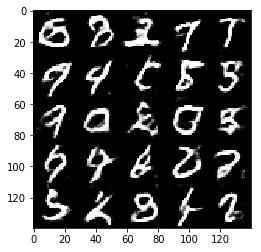

Epoch 2/2... Discriminator Loss: 1.5779... Generator Loss: 0.4282
Epoch 2/2... Discriminator Loss: 1.4167... Generator Loss: 1.4779
Epoch 2/2... Discriminator Loss: 1.0403... Generator Loss: 1.6113


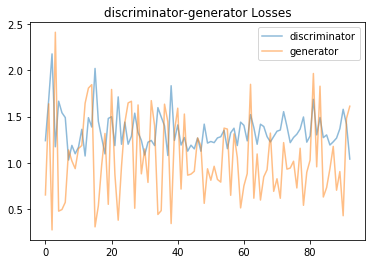

In [27]:
batch_size = 128
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Input Stage
Generator Stage
(?, 28, 28, 3)
disciminator stage
(?, 14, 14, 64)
(?, 7, 7, 128)
disciminator stage
(?, 14, 14, 64)
(?, 7, 7, 128)
Epoch 1/1... Discriminator Loss: 0.6482... Generator Loss: 1.6647
Epoch 1/1... Discriminator Loss: 0.5928... Generator Loss: 1.8150
Epoch 1/1... Discriminator Loss: 0.6113... Generator Loss: 1.7489
Epoch 1/1... Discriminator Loss: 0.4702... Generator Loss: 2.5355
Epoch 1/1... Discriminator Loss: 0.6243... Generator Loss: 1.6820
Epoch 1/1... Discriminator Loss: 0.5043... Generator Loss: 3.4491
Epoch 1/1... Discriminator Loss: 0.8939... Generator Loss: 1.0695
Epoch 1/1... Discriminator Loss: 1.9686... Generator Loss: 0.3842
Epoch 1/1... Discriminator Loss: 0.6794... Generator Loss: 2.2805
Epoch 1/1... Discriminator Loss: 0.6812... Generator Loss: 1.9836
Generator Stage
(?, 28, 28, 3)


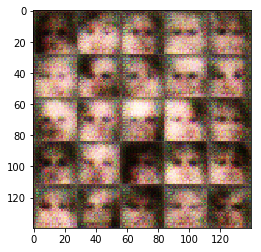

Epoch 1/1... Discriminator Loss: 0.8310... Generator Loss: 1.7604
Epoch 1/1... Discriminator Loss: 0.6995... Generator Loss: 1.9458
Epoch 1/1... Discriminator Loss: 0.6767... Generator Loss: 1.7129
Epoch 1/1... Discriminator Loss: 0.6491... Generator Loss: 1.7939
Epoch 1/1... Discriminator Loss: 0.7275... Generator Loss: 1.4530
Epoch 1/1... Discriminator Loss: 0.8400... Generator Loss: 1.1707
Epoch 1/1... Discriminator Loss: 0.6953... Generator Loss: 1.6244
Epoch 1/1... Discriminator Loss: 0.7699... Generator Loss: 1.3979
Epoch 1/1... Discriminator Loss: 0.7948... Generator Loss: 1.6017
Epoch 1/1... Discriminator Loss: 0.8162... Generator Loss: 1.6007
Generator Stage
(?, 28, 28, 3)


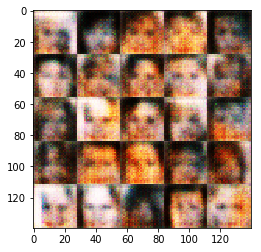

Epoch 1/1... Discriminator Loss: 0.7362... Generator Loss: 2.2081
Epoch 1/1... Discriminator Loss: 0.7800... Generator Loss: 1.5611
Epoch 1/1... Discriminator Loss: 0.9656... Generator Loss: 0.9515
Epoch 1/1... Discriminator Loss: 0.9793... Generator Loss: 1.0724
Epoch 1/1... Discriminator Loss: 0.9794... Generator Loss: 1.8855
Epoch 1/1... Discriminator Loss: 0.9255... Generator Loss: 1.0961
Epoch 1/1... Discriminator Loss: 0.9786... Generator Loss: 1.0564
Epoch 1/1... Discriminator Loss: 0.9240... Generator Loss: 1.2000
Epoch 1/1... Discriminator Loss: 0.7936... Generator Loss: 1.5828
Epoch 1/1... Discriminator Loss: 0.8713... Generator Loss: 1.1402
Generator Stage
(?, 28, 28, 3)


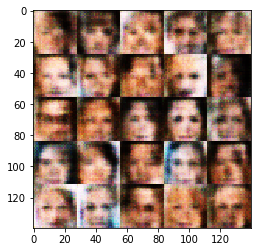

Epoch 1/1... Discriminator Loss: 1.0639... Generator Loss: 2.4367
Epoch 1/1... Discriminator Loss: 0.8858... Generator Loss: 1.1074
Epoch 1/1... Discriminator Loss: 0.9677... Generator Loss: 1.8824
Epoch 1/1... Discriminator Loss: 0.8887... Generator Loss: 1.4704
Epoch 1/1... Discriminator Loss: 0.9097... Generator Loss: 1.4456
Epoch 1/1... Discriminator Loss: 0.8219... Generator Loss: 1.2399
Epoch 1/1... Discriminator Loss: 0.8299... Generator Loss: 1.5485
Epoch 1/1... Discriminator Loss: 1.0558... Generator Loss: 0.9588
Epoch 1/1... Discriminator Loss: 0.8497... Generator Loss: 1.4788
Epoch 1/1... Discriminator Loss: 1.1673... Generator Loss: 2.4678
Generator Stage
(?, 28, 28, 3)


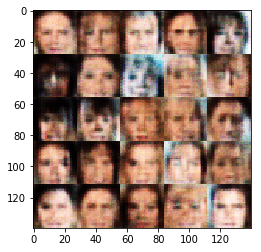

Epoch 1/1... Discriminator Loss: 0.9063... Generator Loss: 1.0857
Epoch 1/1... Discriminator Loss: 0.9608... Generator Loss: 1.6783
Epoch 1/1... Discriminator Loss: 0.7585... Generator Loss: 1.4931
Epoch 1/1... Discriminator Loss: 0.9350... Generator Loss: 1.2143
Epoch 1/1... Discriminator Loss: 1.2321... Generator Loss: 0.6198
Epoch 1/1... Discriminator Loss: 0.8738... Generator Loss: 1.3601
Epoch 1/1... Discriminator Loss: 1.0064... Generator Loss: 1.0178
Epoch 1/1... Discriminator Loss: 0.9569... Generator Loss: 1.4277
Epoch 1/1... Discriminator Loss: 1.2523... Generator Loss: 0.5973
Epoch 1/1... Discriminator Loss: 0.9263... Generator Loss: 1.2467
Generator Stage
(?, 28, 28, 3)


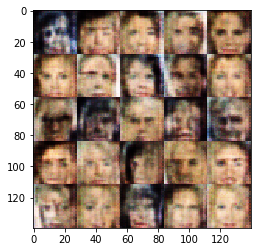

Epoch 1/1... Discriminator Loss: 0.9279... Generator Loss: 1.0925
Epoch 1/1... Discriminator Loss: 1.1456... Generator Loss: 0.7132
Epoch 1/1... Discriminator Loss: 1.1109... Generator Loss: 0.8414
Epoch 1/1... Discriminator Loss: 1.3067... Generator Loss: 0.8348
Epoch 1/1... Discriminator Loss: 0.9858... Generator Loss: 1.0596
Epoch 1/1... Discriminator Loss: 1.0534... Generator Loss: 0.8897
Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.5129
Epoch 1/1... Discriminator Loss: 1.1634... Generator Loss: 0.8546
Epoch 1/1... Discriminator Loss: 0.9989... Generator Loss: 1.2531
Epoch 1/1... Discriminator Loss: 1.6274... Generator Loss: 2.3886
Generator Stage
(?, 28, 28, 3)


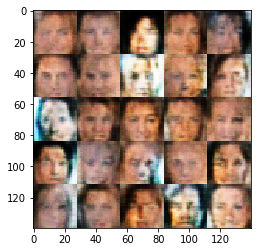

Epoch 1/1... Discriminator Loss: 1.0674... Generator Loss: 1.0835
Epoch 1/1... Discriminator Loss: 1.1621... Generator Loss: 0.7912
Epoch 1/1... Discriminator Loss: 1.2008... Generator Loss: 1.6882
Epoch 1/1... Discriminator Loss: 1.0313... Generator Loss: 1.0559
Epoch 1/1... Discriminator Loss: 1.2222... Generator Loss: 0.7277
Epoch 1/1... Discriminator Loss: 1.0257... Generator Loss: 1.3160
Epoch 1/1... Discriminator Loss: 1.1474... Generator Loss: 0.9088
Epoch 1/1... Discriminator Loss: 1.1741... Generator Loss: 1.2339
Epoch 1/1... Discriminator Loss: 1.4676... Generator Loss: 2.3744
Epoch 1/1... Discriminator Loss: 1.0847... Generator Loss: 1.2649
Generator Stage
(?, 28, 28, 3)


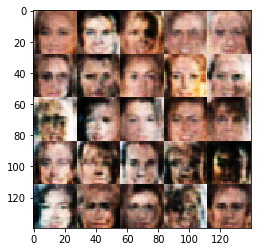

Epoch 1/1... Discriminator Loss: 1.2637... Generator Loss: 0.8344
Epoch 1/1... Discriminator Loss: 1.2058... Generator Loss: 1.0071
Epoch 1/1... Discriminator Loss: 1.2641... Generator Loss: 1.5095
Epoch 1/1... Discriminator Loss: 1.1183... Generator Loss: 1.0522
Epoch 1/1... Discriminator Loss: 1.1738... Generator Loss: 1.0930
Epoch 1/1... Discriminator Loss: 1.0880... Generator Loss: 1.0254
Epoch 1/1... Discriminator Loss: 1.0419... Generator Loss: 1.1328
Epoch 1/1... Discriminator Loss: 1.0055... Generator Loss: 1.3606
Epoch 1/1... Discriminator Loss: 1.3125... Generator Loss: 0.6951
Epoch 1/1... Discriminator Loss: 1.5537... Generator Loss: 0.5747
Generator Stage
(?, 28, 28, 3)


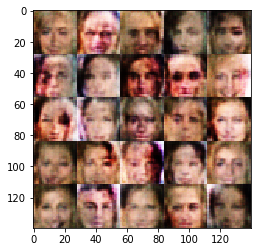

Epoch 1/1... Discriminator Loss: 1.1103... Generator Loss: 0.8664
Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 1.8950
Epoch 1/1... Discriminator Loss: 1.2278... Generator Loss: 1.0559
Epoch 1/1... Discriminator Loss: 1.2049... Generator Loss: 0.8000
Epoch 1/1... Discriminator Loss: 1.1622... Generator Loss: 1.2095
Epoch 1/1... Discriminator Loss: 1.1785... Generator Loss: 0.9721
Epoch 1/1... Discriminator Loss: 1.3069... Generator Loss: 0.9247
Epoch 1/1... Discriminator Loss: 1.1314... Generator Loss: 1.0361
Epoch 1/1... Discriminator Loss: 1.4491... Generator Loss: 1.6333
Epoch 1/1... Discriminator Loss: 1.4015... Generator Loss: 0.8107
Generator Stage
(?, 28, 28, 3)


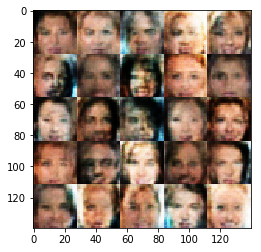

Epoch 1/1... Discriminator Loss: 1.3331... Generator Loss: 0.6906
Epoch 1/1... Discriminator Loss: 1.4454... Generator Loss: 0.5027
Epoch 1/1... Discriminator Loss: 1.3445... Generator Loss: 0.8737
Epoch 1/1... Discriminator Loss: 1.2107... Generator Loss: 0.9996
Epoch 1/1... Discriminator Loss: 1.0982... Generator Loss: 1.0510
Epoch 1/1... Discriminator Loss: 1.1963... Generator Loss: 1.2791
Epoch 1/1... Discriminator Loss: 1.1659... Generator Loss: 0.9591
Epoch 1/1... Discriminator Loss: 1.3046... Generator Loss: 0.7218
Epoch 1/1... Discriminator Loss: 1.2577... Generator Loss: 0.9378
Epoch 1/1... Discriminator Loss: 1.1281... Generator Loss: 0.9888
Generator Stage
(?, 28, 28, 3)


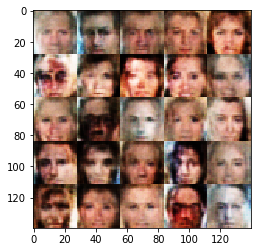

Epoch 1/1... Discriminator Loss: 1.3132... Generator Loss: 1.3819
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.5484
Epoch 1/1... Discriminator Loss: 1.2485... Generator Loss: 0.7024
Epoch 1/1... Discriminator Loss: 1.3582... Generator Loss: 1.0011
Epoch 1/1... Discriminator Loss: 1.2278... Generator Loss: 0.7431
Epoch 1/1... Discriminator Loss: 1.2897... Generator Loss: 0.8465
Epoch 1/1... Discriminator Loss: 1.3079... Generator Loss: 0.7871
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.5182
Epoch 1/1... Discriminator Loss: 1.2936... Generator Loss: 0.8850
Epoch 1/1... Discriminator Loss: 1.2610... Generator Loss: 0.7180
Generator Stage
(?, 28, 28, 3)


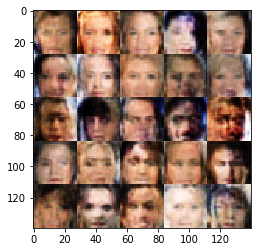

Epoch 1/1... Discriminator Loss: 1.3459... Generator Loss: 1.2410
Epoch 1/1... Discriminator Loss: 1.2628... Generator Loss: 1.0318
Epoch 1/1... Discriminator Loss: 1.2929... Generator Loss: 1.0263
Epoch 1/1... Discriminator Loss: 1.2609... Generator Loss: 0.7765
Epoch 1/1... Discriminator Loss: 1.2618... Generator Loss: 0.7691
Epoch 1/1... Discriminator Loss: 1.3426... Generator Loss: 1.0842
Epoch 1/1... Discriminator Loss: 1.2286... Generator Loss: 1.0392
Epoch 1/1... Discriminator Loss: 1.3729... Generator Loss: 0.8060
Epoch 1/1... Discriminator Loss: 1.2517... Generator Loss: 0.7561
Epoch 1/1... Discriminator Loss: 1.2729... Generator Loss: 0.7091
Generator Stage
(?, 28, 28, 3)


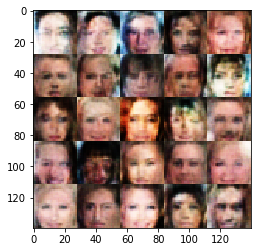

Epoch 1/1... Discriminator Loss: 1.3353... Generator Loss: 0.8998
Epoch 1/1... Discriminator Loss: 1.3149... Generator Loss: 1.3661
Epoch 1/1... Discriminator Loss: 1.4233... Generator Loss: 0.5513
Epoch 1/1... Discriminator Loss: 1.6027... Generator Loss: 0.4080
Epoch 1/1... Discriminator Loss: 1.2764... Generator Loss: 1.2486
Epoch 1/1... Discriminator Loss: 1.3685... Generator Loss: 0.7639
Epoch 1/1... Discriminator Loss: 1.2622... Generator Loss: 0.8718
Epoch 1/1... Discriminator Loss: 1.2624... Generator Loss: 0.7156
Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.5795
Epoch 1/1... Discriminator Loss: 1.2743... Generator Loss: 0.7816
Generator Stage
(?, 28, 28, 3)


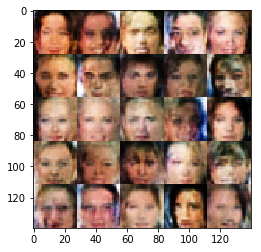

Epoch 1/1... Discriminator Loss: 1.3288... Generator Loss: 0.8253
Epoch 1/1... Discriminator Loss: 1.2562... Generator Loss: 0.7547
Epoch 1/1... Discriminator Loss: 1.2141... Generator Loss: 1.1996
Epoch 1/1... Discriminator Loss: 1.1956... Generator Loss: 1.0211
Epoch 1/1... Discriminator Loss: 1.3705... Generator Loss: 0.5428
Epoch 1/1... Discriminator Loss: 1.2804... Generator Loss: 1.2160
Epoch 1/1... Discriminator Loss: 1.2210... Generator Loss: 0.9775
Epoch 1/1... Discriminator Loss: 1.3288... Generator Loss: 0.9026
Epoch 1/1... Discriminator Loss: 1.2548... Generator Loss: 1.2341
Epoch 1/1... Discriminator Loss: 1.1877... Generator Loss: 1.1096
Generator Stage
(?, 28, 28, 3)


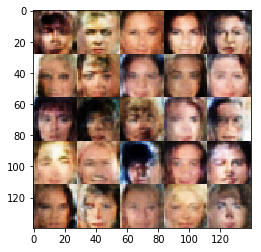

Epoch 1/1... Discriminator Loss: 1.4459... Generator Loss: 0.5789
Epoch 1/1... Discriminator Loss: 1.2876... Generator Loss: 0.6954
Epoch 1/1... Discriminator Loss: 1.2917... Generator Loss: 0.7889
Epoch 1/1... Discriminator Loss: 1.3101... Generator Loss: 1.3325
Epoch 1/1... Discriminator Loss: 1.2982... Generator Loss: 0.7599
Epoch 1/1... Discriminator Loss: 1.2229... Generator Loss: 0.8126
Epoch 1/1... Discriminator Loss: 1.3102... Generator Loss: 1.0169
Epoch 1/1... Discriminator Loss: 1.2766... Generator Loss: 0.6722
Epoch 1/1... Discriminator Loss: 1.2847... Generator Loss: 0.6578
Epoch 1/1... Discriminator Loss: 1.2519... Generator Loss: 0.8474
Generator Stage
(?, 28, 28, 3)


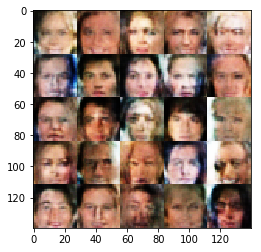

Epoch 1/1... Discriminator Loss: 1.2069... Generator Loss: 1.0889
Epoch 1/1... Discriminator Loss: 1.2128... Generator Loss: 1.0618
Epoch 1/1... Discriminator Loss: 1.1742... Generator Loss: 1.3076
Epoch 1/1... Discriminator Loss: 1.2361... Generator Loss: 0.9315
Epoch 1/1... Discriminator Loss: 1.4368... Generator Loss: 1.0204
Epoch 1/1... Discriminator Loss: 1.2910... Generator Loss: 1.1076
Epoch 1/1... Discriminator Loss: 1.2086... Generator Loss: 1.3751
Epoch 1/1... Discriminator Loss: 1.2545... Generator Loss: 0.8778
Epoch 1/1... Discriminator Loss: 1.3545... Generator Loss: 0.9133
Epoch 1/1... Discriminator Loss: 1.2801... Generator Loss: 0.8623
Generator Stage
(?, 28, 28, 3)


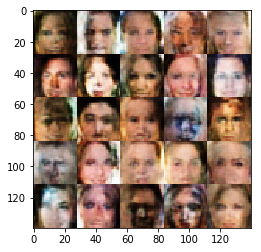

Epoch 1/1... Discriminator Loss: 1.2879... Generator Loss: 0.9620
Epoch 1/1... Discriminator Loss: 1.2658... Generator Loss: 0.9749
Epoch 1/1... Discriminator Loss: 1.3847... Generator Loss: 0.6700
Epoch 1/1... Discriminator Loss: 1.3212... Generator Loss: 0.7515
Epoch 1/1... Discriminator Loss: 1.1528... Generator Loss: 0.9719
Epoch 1/1... Discriminator Loss: 1.2385... Generator Loss: 0.8543
Epoch 1/1... Discriminator Loss: 1.2644... Generator Loss: 0.9722
Epoch 1/1... Discriminator Loss: 1.2786... Generator Loss: 0.9064
Epoch 1/1... Discriminator Loss: 1.2864... Generator Loss: 0.7326
Epoch 1/1... Discriminator Loss: 1.3765... Generator Loss: 0.6637
Generator Stage
(?, 28, 28, 3)


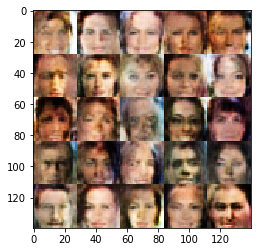

Epoch 1/1... Discriminator Loss: 1.2777... Generator Loss: 1.0169
Epoch 1/1... Discriminator Loss: 1.4818... Generator Loss: 1.1806
Epoch 1/1... Discriminator Loss: 1.4817... Generator Loss: 1.6981
Epoch 1/1... Discriminator Loss: 1.2581... Generator Loss: 1.0171
Epoch 1/1... Discriminator Loss: 1.3671... Generator Loss: 1.1524
Epoch 1/1... Discriminator Loss: 1.2223... Generator Loss: 1.1339
Epoch 1/1... Discriminator Loss: 1.2721... Generator Loss: 0.9979
Epoch 1/1... Discriminator Loss: 1.2246... Generator Loss: 0.8664
Epoch 1/1... Discriminator Loss: 1.3215... Generator Loss: 0.7873
Epoch 1/1... Discriminator Loss: 1.3014... Generator Loss: 1.0299
Generator Stage
(?, 28, 28, 3)


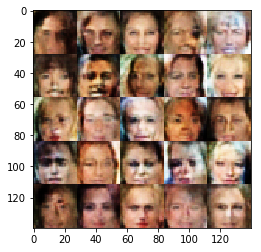

Epoch 1/1... Discriminator Loss: 1.3553... Generator Loss: 1.3256
Epoch 1/1... Discriminator Loss: 1.2065... Generator Loss: 1.0339
Epoch 1/1... Discriminator Loss: 1.2717... Generator Loss: 1.0134
Epoch 1/1... Discriminator Loss: 1.1641... Generator Loss: 0.9208
Epoch 1/1... Discriminator Loss: 1.2781... Generator Loss: 1.0263
Epoch 1/1... Discriminator Loss: 1.3140... Generator Loss: 0.8701
Epoch 1/1... Discriminator Loss: 1.3084... Generator Loss: 0.7019
Epoch 1/1... Discriminator Loss: 1.3236... Generator Loss: 0.9241
Epoch 1/1... Discriminator Loss: 1.2591... Generator Loss: 1.5845
Epoch 1/1... Discriminator Loss: 1.3113... Generator Loss: 0.9067
Generator Stage
(?, 28, 28, 3)


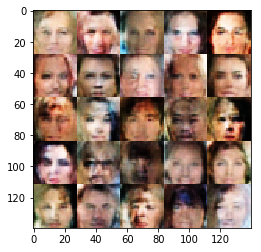

Epoch 1/1... Discriminator Loss: 1.2410... Generator Loss: 0.7461
Epoch 1/1... Discriminator Loss: 1.2994... Generator Loss: 0.8429
Epoch 1/1... Discriminator Loss: 1.2210... Generator Loss: 0.8576
Epoch 1/1... Discriminator Loss: 1.2742... Generator Loss: 0.9404
Epoch 1/1... Discriminator Loss: 1.2394... Generator Loss: 0.8988
Epoch 1/1... Discriminator Loss: 1.2691... Generator Loss: 0.9558
Epoch 1/1... Discriminator Loss: 1.4715... Generator Loss: 0.4861
Epoch 1/1... Discriminator Loss: 1.1413... Generator Loss: 1.0628
Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 0.6651
Epoch 1/1... Discriminator Loss: 1.3400... Generator Loss: 0.7412
Generator Stage
(?, 28, 28, 3)


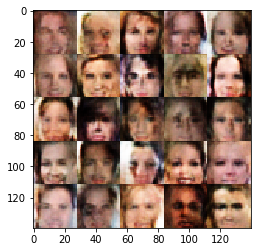

Epoch 1/1... Discriminator Loss: 1.3817... Generator Loss: 0.6015
Epoch 1/1... Discriminator Loss: 1.4370... Generator Loss: 0.5185
Epoch 1/1... Discriminator Loss: 1.2047... Generator Loss: 1.0356
Epoch 1/1... Discriminator Loss: 1.4313... Generator Loss: 0.5451
Epoch 1/1... Discriminator Loss: 1.1729... Generator Loss: 1.3712
Epoch 1/1... Discriminator Loss: 1.3339... Generator Loss: 0.7356
Epoch 1/1... Discriminator Loss: 1.3686... Generator Loss: 0.7128
Epoch 1/1... Discriminator Loss: 1.2984... Generator Loss: 1.1019
Epoch 1/1... Discriminator Loss: 1.4884... Generator Loss: 0.5275
Epoch 1/1... Discriminator Loss: 1.2122... Generator Loss: 0.9659
Generator Stage
(?, 28, 28, 3)


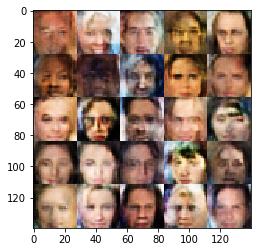

Epoch 1/1... Discriminator Loss: 1.2338... Generator Loss: 0.8212
Epoch 1/1... Discriminator Loss: 1.3145... Generator Loss: 1.1236
Epoch 1/1... Discriminator Loss: 1.2952... Generator Loss: 0.8200
Epoch 1/1... Discriminator Loss: 1.2066... Generator Loss: 1.0733
Epoch 1/1... Discriminator Loss: 1.3647... Generator Loss: 1.1570
Epoch 1/1... Discriminator Loss: 1.2199... Generator Loss: 0.9330
Epoch 1/1... Discriminator Loss: 1.2075... Generator Loss: 1.0468
Epoch 1/1... Discriminator Loss: 1.3374... Generator Loss: 0.6198
Epoch 1/1... Discriminator Loss: 1.3097... Generator Loss: 1.1001
Epoch 1/1... Discriminator Loss: 1.2260... Generator Loss: 0.9518
Generator Stage
(?, 28, 28, 3)


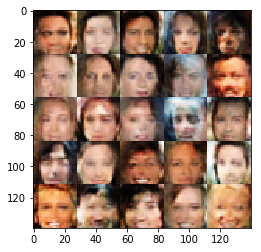

Epoch 1/1... Discriminator Loss: 1.3372... Generator Loss: 1.0141
Epoch 1/1... Discriminator Loss: 1.3125... Generator Loss: 0.7262
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 1.1586
Epoch 1/1... Discriminator Loss: 1.1683... Generator Loss: 1.3573
Epoch 1/1... Discriminator Loss: 1.1793... Generator Loss: 1.0420
Epoch 1/1... Discriminator Loss: 1.2429... Generator Loss: 0.9045
Epoch 1/1... Discriminator Loss: 1.3173... Generator Loss: 0.8477
Epoch 1/1... Discriminator Loss: 1.2413... Generator Loss: 0.8828
Epoch 1/1... Discriminator Loss: 2.3305... Generator Loss: 3.4886
Epoch 1/1... Discriminator Loss: 1.4372... Generator Loss: 2.1624
Generator Stage
(?, 28, 28, 3)


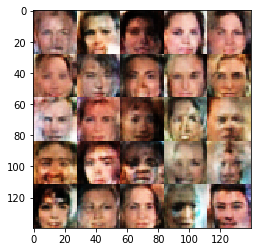

Epoch 1/1... Discriminator Loss: 1.2259... Generator Loss: 1.0254
Epoch 1/1... Discriminator Loss: 1.2739... Generator Loss: 0.8210
Epoch 1/1... Discriminator Loss: 1.1899... Generator Loss: 0.9000
Epoch 1/1... Discriminator Loss: 1.1904... Generator Loss: 0.8167
Epoch 1/1... Discriminator Loss: 1.1355... Generator Loss: 1.0081
Epoch 1/1... Discriminator Loss: 1.1627... Generator Loss: 1.2256
Epoch 1/1... Discriminator Loss: 1.2952... Generator Loss: 0.7636
Epoch 1/1... Discriminator Loss: 1.2029... Generator Loss: 1.3374
Epoch 1/1... Discriminator Loss: 1.2587... Generator Loss: 0.6918
Epoch 1/1... Discriminator Loss: 1.2369... Generator Loss: 1.0094
Generator Stage
(?, 28, 28, 3)


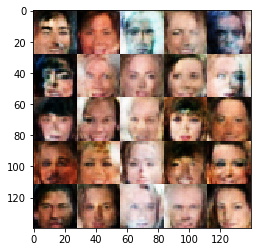

Epoch 1/1... Discriminator Loss: 1.2230... Generator Loss: 0.9399
Epoch 1/1... Discriminator Loss: 1.2772... Generator Loss: 0.9429
Epoch 1/1... Discriminator Loss: 1.1973... Generator Loss: 1.2850
Epoch 1/1... Discriminator Loss: 1.2756... Generator Loss: 0.9545
Epoch 1/1... Discriminator Loss: 1.3005... Generator Loss: 1.2577
Epoch 1/1... Discriminator Loss: 1.6269... Generator Loss: 0.4085
Epoch 1/1... Discriminator Loss: 1.2880... Generator Loss: 0.8437
Epoch 1/1... Discriminator Loss: 1.2834... Generator Loss: 0.8715
Epoch 1/1... Discriminator Loss: 1.1806... Generator Loss: 0.7805
Epoch 1/1... Discriminator Loss: 1.2286... Generator Loss: 0.9546
Generator Stage
(?, 28, 28, 3)


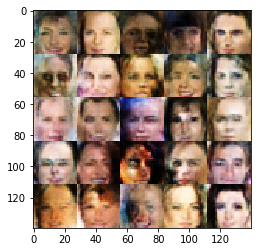

Epoch 1/1... Discriminator Loss: 1.3001... Generator Loss: 0.7490
Epoch 1/1... Discriminator Loss: 1.2518... Generator Loss: 0.7038
Epoch 1/1... Discriminator Loss: 1.4095... Generator Loss: 0.7458
Epoch 1/1... Discriminator Loss: 1.1910... Generator Loss: 0.8014
Epoch 1/1... Discriminator Loss: 1.2935... Generator Loss: 0.7688
Epoch 1/1... Discriminator Loss: 1.2307... Generator Loss: 1.0664
Epoch 1/1... Discriminator Loss: 1.2008... Generator Loss: 1.0939
Epoch 1/1... Discriminator Loss: 1.3207... Generator Loss: 0.7264
Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.6262
Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.7048
Generator Stage
(?, 28, 28, 3)


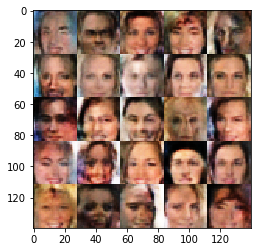

Epoch 1/1... Discriminator Loss: 1.1486... Generator Loss: 0.9766
Epoch 1/1... Discriminator Loss: 1.3597... Generator Loss: 0.9263
Epoch 1/1... Discriminator Loss: 1.2432... Generator Loss: 0.9399
Epoch 1/1... Discriminator Loss: 1.3316... Generator Loss: 0.7492
Epoch 1/1... Discriminator Loss: 1.3144... Generator Loss: 0.9523
Epoch 1/1... Discriminator Loss: 1.2382... Generator Loss: 1.2740
Epoch 1/1... Discriminator Loss: 1.4031... Generator Loss: 0.7446
Epoch 1/1... Discriminator Loss: 1.2973... Generator Loss: 0.8020
Epoch 1/1... Discriminator Loss: 1.2378... Generator Loss: 0.8959
Epoch 1/1... Discriminator Loss: 1.4148... Generator Loss: 0.7204
Generator Stage
(?, 28, 28, 3)


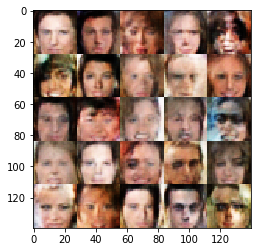

Epoch 1/1... Discriminator Loss: 1.2726... Generator Loss: 0.7079
Epoch 1/1... Discriminator Loss: 1.2591... Generator Loss: 0.7101
Epoch 1/1... Discriminator Loss: 1.5537... Generator Loss: 0.4704
Epoch 1/1... Discriminator Loss: 1.2847... Generator Loss: 1.1138
Epoch 1/1... Discriminator Loss: 1.1720... Generator Loss: 0.9247
Epoch 1/1... Discriminator Loss: 1.2893... Generator Loss: 0.9484
Epoch 1/1... Discriminator Loss: 1.2205... Generator Loss: 1.1606
Epoch 1/1... Discriminator Loss: 1.3213... Generator Loss: 1.0319
Epoch 1/1... Discriminator Loss: 1.4158... Generator Loss: 0.8288
Epoch 1/1... Discriminator Loss: 1.1532... Generator Loss: 1.1236
Generator Stage
(?, 28, 28, 3)


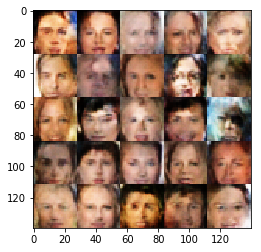

Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.6238
Epoch 1/1... Discriminator Loss: 1.2418... Generator Loss: 0.8085
Epoch 1/1... Discriminator Loss: 1.2033... Generator Loss: 1.1783
Epoch 1/1... Discriminator Loss: 1.2832... Generator Loss: 0.7703
Epoch 1/1... Discriminator Loss: 1.1365... Generator Loss: 0.9616
Epoch 1/1... Discriminator Loss: 1.1581... Generator Loss: 1.0736
Epoch 1/1... Discriminator Loss: 1.8594... Generator Loss: 2.3090
Epoch 1/1... Discriminator Loss: 1.3116... Generator Loss: 1.0192
Epoch 1/1... Discriminator Loss: 1.2649... Generator Loss: 0.9208
Epoch 1/1... Discriminator Loss: 1.3140... Generator Loss: 0.9063
Generator Stage
(?, 28, 28, 3)


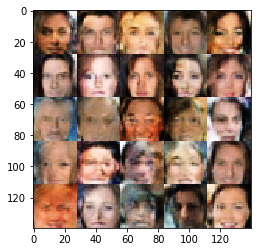

Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 0.7318
Epoch 1/1... Discriminator Loss: 1.1966... Generator Loss: 1.1921
Epoch 1/1... Discriminator Loss: 1.2623... Generator Loss: 0.7972
Epoch 1/1... Discriminator Loss: 1.3149... Generator Loss: 0.8976
Epoch 1/1... Discriminator Loss: 1.2602... Generator Loss: 0.7420
Epoch 1/1... Discriminator Loss: 1.1572... Generator Loss: 1.3368
Epoch 1/1... Discriminator Loss: 1.2649... Generator Loss: 0.8861
Epoch 1/1... Discriminator Loss: 1.3121... Generator Loss: 0.9343
Epoch 1/1... Discriminator Loss: 1.2641... Generator Loss: 0.8845
Epoch 1/1... Discriminator Loss: 1.5701... Generator Loss: 0.4325
Generator Stage
(?, 28, 28, 3)


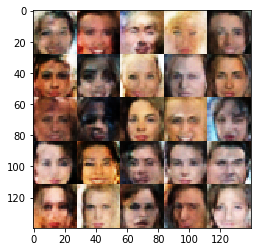

Epoch 1/1... Discriminator Loss: 1.3106... Generator Loss: 0.8983
Epoch 1/1... Discriminator Loss: 1.3157... Generator Loss: 0.6653
Epoch 1/1... Discriminator Loss: 1.3245... Generator Loss: 1.0234
Epoch 1/1... Discriminator Loss: 1.3118... Generator Loss: 0.8406
Epoch 1/1... Discriminator Loss: 1.2784... Generator Loss: 0.6593
Epoch 1/1... Discriminator Loss: 1.2346... Generator Loss: 1.0263
Epoch 1/1... Discriminator Loss: 1.1509... Generator Loss: 0.8753
Epoch 1/1... Discriminator Loss: 1.2256... Generator Loss: 0.9179
Epoch 1/1... Discriminator Loss: 1.2321... Generator Loss: 0.9364
Epoch 1/1... Discriminator Loss: 1.1429... Generator Loss: 0.8253
Generator Stage
(?, 28, 28, 3)


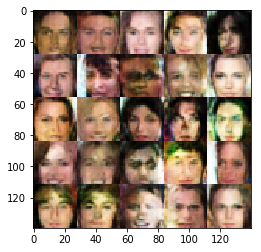

Epoch 1/1... Discriminator Loss: 1.2973... Generator Loss: 0.8658
Epoch 1/1... Discriminator Loss: 1.3116... Generator Loss: 0.7536
Epoch 1/1... Discriminator Loss: 1.2507... Generator Loss: 0.9131
Epoch 1/1... Discriminator Loss: 1.1834... Generator Loss: 0.9715
Epoch 1/1... Discriminator Loss: 1.3316... Generator Loss: 0.6794
Epoch 1/1... Discriminator Loss: 1.3246... Generator Loss: 0.6288


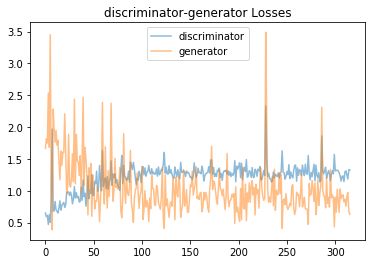

In [28]:
batch_size = 64
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.